In [1]:
import os
import warnings
#os.environ['TORCH_HOME'] = 'D:\\'

#path="/Users/FrePoe"
#retval=os.getcwd()
#print ("Dir atual %s"% retval)
#os.chdir(path)
#retval=os.getcwd()
#print ("Dir alterado para %s"% retval)
#warnings.filterwarnings("ignore")

#os.chdir("../../..")

In [2]:
import pandas as pd
import torch
import numpy as np
from numpy import mean, absolute, exp
from numpy.random import randn
#from datetime import datetime
import sounddevice as sd
import soundfile as sf
#from sklearn.preprocessing import PowerTransformer
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pickle
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
#print(torch.cuda.is_available())

In [3]:
a = torch.rand(10000, 10000).cuda()
del a
torch.cuda.empty_cache()

In [4]:
pl.seed_everything(42)
deterministic=True #reduz erro aleatóro entre simulação
#parametros de entrada            #<<<< 
acao                  ='VALE3'   #<<<< IMPORTAR PELO MENOS 1000 CANDLES
indice                ='IBOV'
tempo_min             = 15        #por enquanto 10 ou 15min de intervalo candle  #<<<< 
tempo                 = str(tempo_min)+'min'
max_encoder_length    = 20       #<<<<   encontrar padrao de variação - 80 corresponde a 2,5 dias - 160 5d semana
max_prediction_length = 5        #<<<<   corresponde à 1/4 - 1/3 do max encoder fixo // 21 63; 8 32; 
linhas_menos          = 1200      #<<<< numero de ultimas linha para trabalhar na simulacao // 1200
periodo_cci           = 3         #<<<< periodo da média CCI do indicador adaptado  (linha vermelha)
periodo_cci_b         = 11        #<<<< periodo da média CCI do indicador adaptado (linha verde)
mov_aver_cci          = 13        #<<<< +++periodo moving average para APAGAR linhas
periodo_mov           = 57        #<<<< periodo moving average Williams AD
periodo_ema           = 3         #<<<< periodo EMA Close
periodo_ema_b         = 7         #<<<< periodo EMA Close
periodo_ema_c         = 11         #<<<< periodo EMA Close

# ENCODERS - - valores ideais: 80/20 boa precisão e aderência geral 80/16 mais preciso na previsão
# encoder acima de 120 tem boa aderencia ao passado mas a previsao não é boa para o fim do vetor de prediction

#leitura arquivo
 # /Users/FrePoe/GDrive Testmat ...para mac
 # D:/GoogleDrive               ...para windows
data = pd.read_csv (f'D:/GoogleDrive/trade_conda_bkp/fusion/{acao}.csv', 
                    delimiter='\t',
                    usecols=["<DATE>", "<TIME>", "<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>", "<VOL>"])
ibov = pd.read_csv (f'D:/GoogleDrive/trade_conda_bkp/fusion/{indice}.csv', 
                    delimiter='\t',
                    usecols=["<DATE>", "<TIME>", "<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>", "<VOL>"])


length_a = len (data)
data=data[length_a-linhas_menos-500:] #linhas para a simulação + linhas de cálculo

length_a = len (ibov)
ibov=ibov[length_a-linhas_menos-500:]


data_length_start = len(data)

data ["time_idx"] = np.arange(0,data_length_start,1)
ibov ["time_idx"] = np.arange(0,data_length_start,1)
data["static"] = "0"
data = data.reset_index(drop=True)
ibov = ibov.reset_index(drop=True)


data["<DATE>"]=pd.to_datetime(data["<DATE>"] + ' ' + data["<TIME>"])
del data["<TIME>"]
del ibov["<TIME>"]

# add time index
data['<DATE>'] = pd.to_datetime(data['<DATE>'], format = '%Y-%M-%D %H:%M:%S')

data.rename(columns={'<DATE>':'date', '<OPEN>':'open', '<HIGH>':'high', 
                        '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol' }, inplace=True)
data["series"] = 0

ibov.rename(columns={'<DATE>':'date', '<OPEN>':'open', '<HIGH>':'high', 
                        '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol' }, inplace=True)

#print (ibov)


In [5]:
# conversao para heikin ashi
#HAclose = (O0 + H0 + L0 + C0) / 4
#HAopen = (HAopen-1 + HAclose-1) / 2
#HAhigh = máx(H0, HAopen0, HAclose0)
#HAlow = mín(L0, HAopen0, HAclose0)

def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2
        
    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)
    
    return heikin_ashi_df

dataha = heikin_ashi(data)
data['open'] = dataha['open']
data['high'] = dataha['high']
data['low']  = dataha['low']
data['close']= dataha['close']

dataha = heikin_ashi(ibov)
#data['ibv_vol']  = ibov['vol'] #deixar para copiar as colunas ibov mais abaixo
#data['ibv_close']= dataha['close']

#print (ibov)

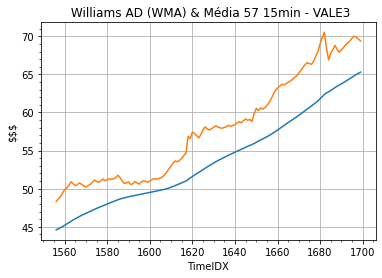

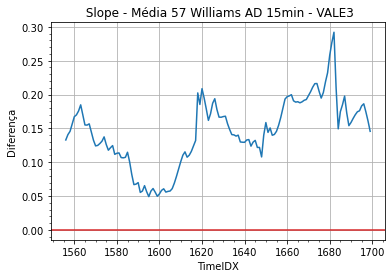

In [6]:
# Cálculo William's Accumulation/Distribution
#Source: https://www.metastock.com/customer/resources/taaz/?p=125
#Params: 
#    data: pandas DataFrame
#	high_col: the name of the HIGH values column
#	low_col: the name of the LOW values column
#	close_col: the name of the CLOSE values column
#    
#Returns:
#    copy of 'data' DataFrame with 'williams_ad' column added
#

def williams_ad(dataw, high_col='high', low_col='low', close_col='close'):
    dataw['williams_ad'] = 0.
    
    for index,row in dataw.iterrows():
        if index > 0:
            prev_value = dataw.at[index-1, 'williams_ad']
            prev_close = dataw.at[index-1, close_col]
            if row[close_col] > prev_close:
                ad = row[close_col] - min(prev_close, row[low_col])
            elif row[close_col] < prev_close:
                ad = row[close_col] - max(prev_close, row[high_col])
            else:
                ad = 0.
                                                                                                        
            dataw.at[index, 'williams_ad'] = ad+prev_value
        
    return dataw

data = williams_ad(data)

data['wma'] = data.iloc[:,-1].ewm(#alpha=1.0/periodo_mov
                                   span=periodo_mov, adjust=True, min_periods=periodo_mov).mean()

data['diff'] = data.wma.diff()

data = data [periodo_mov-1:]
data_length = len(data)
data_plot=data[data_length_start-200:] #imprime só as 200 ultimas linhas


fig, ax = plt.subplots()
ax.plot(data_plot['wma'])
ax.plot(data_plot['williams_ad'])
ax.set(xlabel='TimeIDX', ylabel='$$$',
       title= ' Williams AD (WMA) & Média 57 ' + tempo + ' - ' + acao)
ax.minorticks_on()
ax.grid()
plt.show()

fig, ax2 = plt.subplots()
ax2.plot(data_plot['diff'])
plt.axhline(y=0, color='tab:red', linestyle='-')
ax2.set(xlabel='TimeIDX', ylabel='Diferença',
       title= ' Slope - Média 57 Williams AD ' + tempo + ' - ' + acao)
ax2.minorticks_on()
ax2.grid()
plt.show()

#print(data)


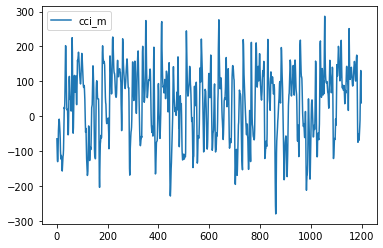

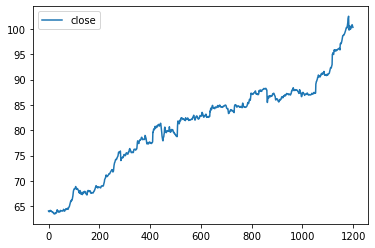

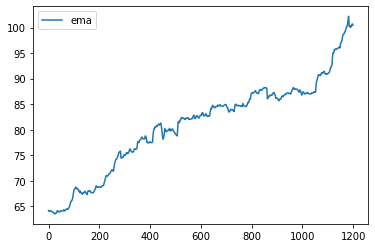

         open        high        low     close      vol  time_idx static  \
0     64.2722   64.272177   63.93000   64.0800  1043000         0      0   
1     64.1761   64.240000   63.97000   64.0900   950200         1      0   
2      64.133   64.133044   63.75000   63.9275   512900         2      0   
3     64.0303   64.040000   63.75000   63.9275   386300         3      0   
4     63.9789   64.100000   63.96000   64.0325   273700         4      0   
...       ...         ...        ...       ...      ...       ...    ...   
1195  100.382  101.040000  100.38186  100.7675  1408100      1195      0   
1196  100.575  101.120000  100.57468  100.8475  2005600      1196      0   
1197  100.711  100.800000  100.55000  100.6825  1016400      1197      0   
1198  100.697  100.720000  100.31000  100.5075  1033500      1198      0   
1199  100.602  100.602147  100.15000  100.3225   991300      1199      0   

      series  williams_ad        wma  ...       ema_b       ema_c      ema_ch  \
0     

In [7]:
#Calculo cci & EMA & KAMA################

def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)               
                
def cci(close, high, low, n, constant): 
 TP = (high + low + close) / 3 
 cci = pd.Series((TP - pd.Series(TP).rolling(window=n).mean()) / (constant * pd.Series(TP).rolling(window=n).apply(mad))) 
                                         #pd.Series(TP).rolling(window=n).mad()))#, name = 'cci_' + str(n)) 
 return cci

def cci_AVERAGE(cci, n):                                    #calculo media do cci
 media = pd.Series(cci).rolling(window=n).mean()
 return media

data['cci'] = cci(data['close'], data['high'], data['low'], 13, 0.015)
data.tail()

data['cci_extra'] = cci(data['close'], data['high'], data['low'], 19, 0.015)
data.tail()

data['cci_m'] = cci_AVERAGE(data['cci'],periodo_cci)        #calculo cci medio curto linha vermelha
data.tail()

data['cci_m_b'] = cci_AVERAGE(data['cci_extra'], periodo_cci_b)  #linha verde cci
data.tail()

                                                            # Cálculo média close EMA 3

data['ema'] = data.iloc[:,-12].ewm(#alpha=1.0/periodo_mov
                                   span=periodo_ema, adjust=True, min_periods=periodo_ema).mean()

data['ema_b'] = data.iloc[:,-13].ewm(#alpha=1.0/periodo_mov
                                   span=periodo_ema_b, adjust=True, min_periods=periodo_ema_b).mean()

data['ema_c'] = data.iloc[:,-14].ewm(#alpha=1.0/periodo_mov
                                   span=periodo_ema_c, adjust=True, min_periods=periodo_ema_c).mean()

data['ema_ch'] = data.iloc[:,-17].rolling(window=10).mean() #canais de alta e baixa

data['ema_cl'] = data.iloc[:,-17].rolling(window=8).mean()

data['wad_m'] = data.iloc[:,-12].rolling(window=3).mean()  #media williams periodo 3

# calculo de vetores de diferença

data['wad_dm'] = data['williams_ad'] - data['wad_m'] # diferenca wad e sua média de 3

data['cci_dm'] = data['cci'] - data['cci_m'] ## diferenca cci e sua média de 3

data['wad_dm_diff'] = data.wad_dm.diff() #calcula slope da media


#copia as colunas faltantes do ibov
#-->
data['ibv_vol']  = ibov['vol']
data['ibv_close']= dataha['close']

data = data [mov_aver_cci+1:] #apaga linhas base para cci


#Cálculo KAMA
#
#def KAMA(price, n=10, pow1=2, pow2=30):
#
#    absDiffx = abs(price - price.shift(1) )
#
#    ER_num = abs( price - price.shift(n) )
#    ER_den = pandas.stats.moments.rolling_sum(absDiffx,n)
#    ER = ER_num / ER_den
#
#    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0
#
#
#   answer = np.zeros(sc.size)
#    N = len(answer)
#    first_value = True
#
#    for i in range(N):
#        if sc[i] != sc[i]:
#            answer[i] = np.nan
#        else:
#            if first_value:
#                answer[i] = price[i]
#                first_value = False
#            else:
#                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
#    return answer
#
#data['kama'] = KAMA(data['close'], n=10, pow1=2, pow2=30)


data_length = len(data)
data=data[data_length-linhas_menos:] #linhas para a simulação
data_length = len(data)
data ["time_idx"] = np.arange(0,data_length,1)
data = data.reset_index(drop=True)

data.plot(y=['cci_m'])
data.plot(y=['close'])
data.plot(y=['ema'])
plt.show()
rw_data_compare = data #dados para teste
periodo_sim=str(rw_data_compare.iloc[-1, rw_data_compare.columns.get_loc('date')]) #periodo para ident do grafico
del data['date']
print (rw_data_compare)

In [8]:
pl.seed_everything(42)
deterministic=True #reduz erro aleatóro entre simulação

training_cutoff = data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='close',
    group_ids=['static'],
    min_encoder_length=max_encoder_length,# // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    add_relative_time_idx=True,
    time_varying_unknown_reals=[
#        'ema',
#        'ema_b',
#        'ema_c',
#        'ema_ch',
#        'ema_cl',
#       'cci',        
#       'cci_m',
#       'cci_m_b',
#      'cci_dm',
       'open',
       'high',
       'low',
       'close',
#       'vol',
#        'wma',
#        'williams_ad',
#        'diff',
#        'wad_dm',
#        'wad_dm_diff',
#        'ibv_vol',
        'ibv_close'
    ],
    allow_missings=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
     #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001, #>0.001
    hidden_size=256,
    lstm_layers=3,
    attention_head_size=3, #menor melhor, era 4
    dropout=0.001, #0.001  #nao adianta dimunuir
    hidden_continuous_size=8, #maior melhor, era 8
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=10, #era 10
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 5473.5k


In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 18.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 64.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 263 

1

In [11]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
#    timeout= 550.0,
    n_trials=250, #original era 200 mas muito demorado...
    max_epochs=100,
    gradient_clip_val_range=(0.01, 3.5), #0.1, 1.0
    hidden_size_range=(8, 320), #hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 96),# hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 5), #1 a 4
    learning_rate_range=(0.003, 0.01),#0.001 a 0.01
    dropout_range=(0.01, 0.4),#0.01 0.03
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False, #use_learning_rate_finder=False # use Optuna to find ideal learning rate or use in-built learning rate finder
)
#5/20
#loss0.081 high,low,ope,clos
#{'gradient_clip_val': 0.9995741060301843, 'hidden_size': 192, 'dropout': 0.19757136520589755, 
#'hidden_continuous_size': 191,'attention_head_size': 3, 'learning_rate': 0.007578142783829319}

#Loss0.095 anterior + ccidm e wa dm
#nao copiei os parametros

#Loss0.127 anteriores + diff
#{'gradient_clip_val': 1.3453909637117754, 'hidden_size': 241, 'dropout': 0.1943836544958564, 
#'hidden_continuous_size': 50, 'attention_head_size': 2, 'learning_rate': 0.009269640952938281}

#Loss0.0947 primeiro + ibov
#{'gradient_clip_val': 1.6560526447390305, 'hidden_size': 256, 'dropout': 0.017582402009162924, 
#'hidden_continuous_size': 50, 'attention_head_size': 1, 'learning_rate': 0.006209569641745704}
#{'gradient_clip_val': 0.4910733016443044, 'hidden_size': 170, 'dropout': 0.01782353873209043,
#'hidden_continuous_size': 54, 'attention_head_size': 1, 'learning_rate': 0.00864707411661148}

#loss0.08 anterior +cci dm
#{'gradient_clip_val': 2.961923242375265, 'hidden_size': 185, 'dropout': 0.05435108484256894, 
# 'hidden_continuous_size': 117, 'attention_head_size': 1, 'learning_rate': 0.00997863797115186}
#{'gradient_clip_val': 2.121368713598508, 'hidden_size': 157, 'dropout': 0.033430671743026885, 
#'hidden_continuous_size': 23, 'attention_head_size': 1, 'learning_rate': 0.009239423089436188}

#Loss0.08 10 mais ibov close + ema3 + ch cl
#{'gradient_clip_val': 0.6014044368332522, 'hidden_size': 252, 'dropout': 0.10623374874978661, 
#'hidden_continuous_size': 93, 'attention_head_size': 2, 'learning_rate': 0.009396748755567065}
#{'gradient_clip_val': 2.4004336259791335, 'hidden_size': 219, 'dropout': 0.016442714505763525, 
#'hidden_continuous_size': 51, 'attention_head_size': 1, 'learning_rate': 0.004976372669771891}

#8/32 igual ao anterior alterado os tempos/periodos


# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-01-10 21:24:17,528] A new study created in memory with name: no-name-2f7aa35b-febf-4d07-a6e5-f8714ba0bbaf
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:28:00,042] Trial 0 finished with value: 0.21573996543884277 and parameters: {'gradient_clip_val': 0.2502954080525601, 'hidden_size': 51, 'dropout': 0.16429245216867952, 'hidden_continuous_size': 18, 'attention_head_size': 1, 'learning_rate': 0.0033563666819728093}. Best is trial 0 with value: 0.21573996543884277.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:31:51,286] Trial 1 finished with value: 0.18968914449214935 and parameters: {'gradient_clip_val': 0.5443698332198517, 'hidden_size': 85, 'dropout': 0.14585976000942935, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.00470685699563521}. Best is trial 1 with value: 0.189689144492149

TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:44:37,945] Trial 35 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:45:17,374] Trial 36 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:45:21,947] Trial 37 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:48:00,316] Trial 38 pruned. Trial was pruned at epoch 64.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:48:05,213] Trial 39 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CU

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:53:18,793] Trial 76 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:53:24,369] Trial 77 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:53:29,190] Trial 78 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:54:07,773] Trial 79 pruned. Trial was pruned at epoch 16.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 21:54:12,435] Trial 80 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using:

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:03:33,955] Trial 117 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:03:39,203] Trial 118 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:03:44,011] Trial 119 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:03:49,027] Trial 120 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:03:53,740] Trial 121 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, us

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:15:54,663] Trial 156 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:15:59,647] Trial 157 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:16:04,665] Trial 158 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:16:09,945] Trial 159 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:16:14,907] Trial 160 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:26:13,117] Trial 196 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:26:17,977] Trial 197 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:26:23,053] Trial 198 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:26:28,309] Trial 199 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:26:33,132] Trial 200 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, us

[I 2021-01-10 22:33:33,716] Trial 236 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:33:45,814] Trial 237 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:33:50,618] Trial 238 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:34:03,677] Trial 239 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:34:08,575] Trial 240 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-10 22:34:13,508] Trial 241 pruned. Trial was

{'gradient_clip_val': 0.22860970144979062, 'hidden_size': 69, 'dropout': 0.09944275283991452, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.005704649977115575}


In [12]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print (best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs\default\version_8\checkpoints\epoch=2-step=26.ckpt


In [13]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
#print(raw_predictions)

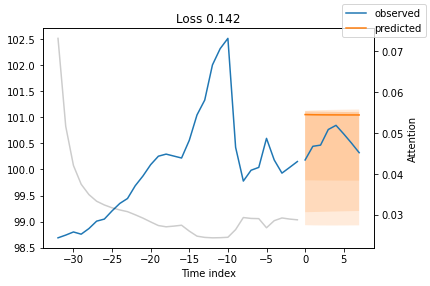

In [14]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [15]:
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]
# select last known data point and create decoder data from it by repeating it and incrementing index
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(time_idx=lambda x: x.time_idx + i) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

C:\Users\Freddy_P\anaconda3\lib\site-packages\pytorch_forecasting\data\timeseries.py:773: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


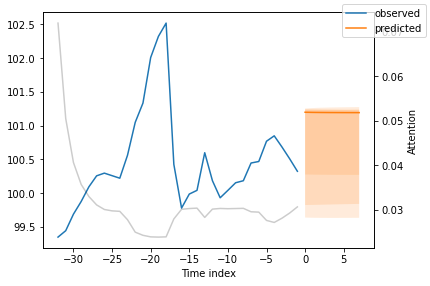

In [16]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw",return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False);
#print (new_raw_predictions)

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x324 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

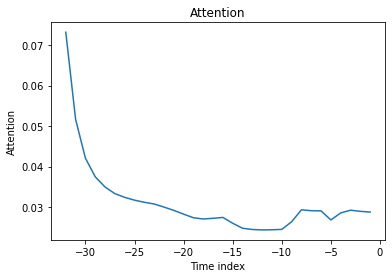

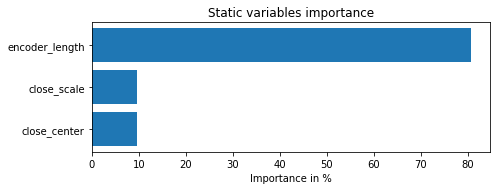

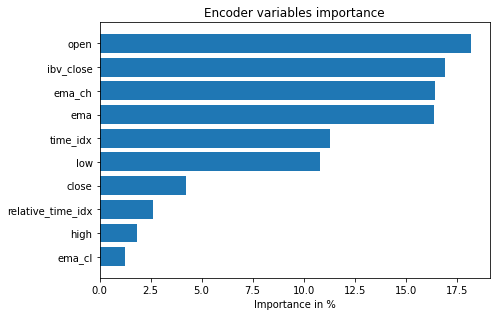

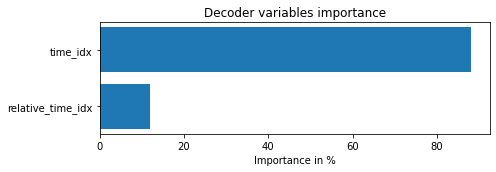

In [17]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [21]:
#prepara os últimos valores do grafico
tempo_real = -1*6*tempo_min #tempo para os pontos reais no grafico

x_lst = np.arange(tempo_real,0,tempo_min)
value_raw = rw_data_compare['close']
data_length = len(value_raw)

linha = data_length-6
i = 0
step = 1
y_compare=[]
while i < 6:
    y = round (value_raw[linha],2)
    y_compare.append(y)
    linha=linha+step 
    i = i + 1 

#manipulacao dos dados para o grafico
previsao, new_x = best_tft.predict(new_prediction_data,return_index=True)
#teste = previsao [:,1].item()
max_prediction_length = 5
tempo_graf = max_prediction_length*tempo_min #tempo grafico e previsao

x_300min = np.arange(0,tempo_graf,tempo_min)

y_1  = round(previsao[:,0].item(),2)
y_2  = round(previsao[:,1].item(),2)
y_3  = round(previsao[:,2].item(),2)
y_4  = round(previsao[:,3].item(),2)
y_5  = round(previsao[:,4].item(),2)
y_300min = [ y_1, y_2, y_3, y_4, y_5 ] 


C:\Users\Freddy_P\anaconda3\lib\site-packages\pytorch_forecasting\data\timeseries.py:773: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


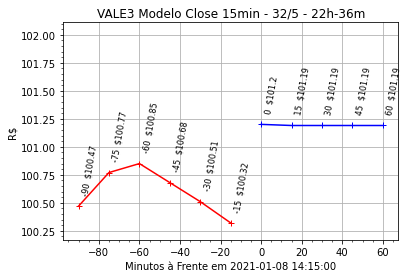

In [22]:
#maximos dos valores
y_mx_graf = np.concatenate((y_300min,y_compare))
y_max = np.max(y_mx_graf)
y_min = np.min(y_mx_graf)

fig, ax = plt.subplots()
now = datetime.now()
hora = now.strftime("%Hh-%Mm")
ax.set(xlabel='Minutos à Frente em '+ periodo_sim, ylabel='R$',
       title= acao + ' Modelo Close ' + tempo + ' - ' + str(max_encoder_length) + '/' + 
            str(max_prediction_length)  +  ' - ' + hora)

#acerta espaço para o grafico nao estorar as anotacoes
plt.ylim(y_min-(.0015*y_min),y_max+(.009*y_max))
ax.plot (x_300min,y_300min,'-b+')
ax.plot (x_lst,y_compare[:],'-r+')

for xy in zip(x_300min,y_300min):
    ax.annotate('     %s  $%s' % xy, xy=xy, xycoords='data', rotation=80, fontsize=8)
    
for xy in zip(x_lst,y_compare):
    ax.annotate('     %s  $%s' % xy, xy=xy, xycoords='data', rotation=80, fontsize=8)


ax.minorticks_on()
ax.grid()
path="D:/GoogleDrive/trade_conda_bkp/sim/" + acao + "_sim_" + hora + '-' + str(max_encoder_length) +'_' + str(max_prediction_length) + ".png"
plt.savefig(path,dpi=180, edgecolor="white", facecolor="white")
plt.show()

In [23]:
filename = 'D:/GoogleDrive/trade_conda_bkp/fim.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playing
sd.play(data, fs)
#status = sd.wait()
#sd.play(data, fs)
status = sd.wait()

In [24]:
#print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_cached())
a = torch.rand(10000, 10000).cuda()
del a
#print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_cached())
torch.cuda.empty_cache()   
#print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_cached())